# Competition for glucose, with internal goods X and Y, and social objective (model), linear/exponential growth rate

In [1]:
import cobra
import pandas as pd
import numpy as np
import pickle
from cobra.flux_analysis import pfba

In [2]:
# import map visualization tools
from utils import show_map
import escher
map_loc = 'Two cell system model_map.json' # the escher map used below
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

M = cobra.io.load_json_model('Two cell system model.json')
model = M.copy()

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


/Users/yanhualiu/Desktop/New_topic/model_building/model_building_exercise_by_yanhua/Cells' competition paper/Two cell types considering growth for paper/utils/findBiomarkers.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
b = show_map([],map_loc)
b

An empty solution was passed.


Builder(hide_secondary_metabolites=False, highlight_missing=True, reaction_data={}, reaction_scale=[{'type': '…

In [3]:
### Internal goods X and Y
model.reactions.EX_Com_goodX_e.lower_bound=0
model.reactions.EX_Com_goodY_e.lower_bound=0
model.reactions.EX_glucose_e.lower_bound=-1

In [4]:
fbasol = pfba(model)
b = show_map(fbasol,map_loc)
b

Builder(hide_secondary_metabolites=False, highlight_missing=True, reaction_data={'EX_glucose_e': -1.0, 'GlcT':…

In [6]:
### FVA result
rxnsOfInterest=['EX_glucose_e','GlcT','GTI1','GTI2','biomass1','biomass2','DI1X','DI2Y']
fvasol = cobra.flux_analysis.flux_variability_analysis(model,reaction_list=rxnsOfInterest,fraction_of_optimum=1)
fvasol

,minimum,maximum
EX_glucose_e,-1.00,-1.00
GlcT,1.00,1.00
GTI1,0.25,0.75
GTI2,0.25,0.75
biomass1,0.00,0.50
biomass2,0.00,0.50
DI1X,0.25,0.25
DI2Y,0.25,0.25


In [7]:
model.solver='glpk'
sol = model.optimize()
sol.objective_value

0.5

## Growing with time (Stepwise growth)

### µ1=0.2; µ2=0.3

In [15]:
model2=model.copy()
model2.objective='biomass1'
model.objective.expression

1.0*biomass1 - 1.0*biomass1_reverse_de634 + 1.0*biomass2 - 1.0*biomass2_reverse_e873d

<Figure size 640x480 with 0 Axes>

0.1538 0.3462 0.1538 0.3462


Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Objective biomass 1 synthesis (µ1=0.2; µ2=0.3; $\\varepsilon=0$)')

Text(0, 0.5, 'Cell number (billions)')

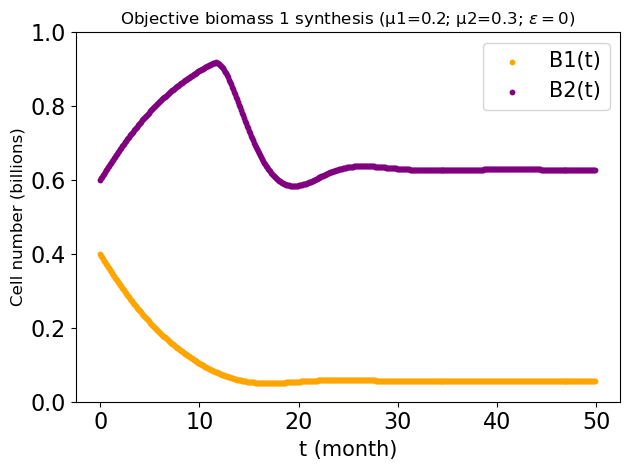

In [16]:
#𝛆=0; Fluxes1=0.1538; Fluxes2=0.3462; b1(0)=0.1538; b2(0)=0.3462
#𝛆=0.5; Fluxes1=0.1762; Fluxes2=0.3238; b1(0)=0.1762; b2(0)=0.3238
#𝛆=1; Fluxes1=0.2; Fluxes2=0.3; b1(0)=0.2; b2(0)=0.3
#𝛆=2; Fluxes1=0.25; Fluxes2=0.25; b1(0)=0.25; b2(0)=0.25
import math
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1538]
Fluxes2_list=[0.3462]

b1_list=[0.1538]
b2_list=[0.3462]

RequiredXproduction_list=[0]
RequiredYproduction_list=[0]
# Store the values of B1 and B2 for each time step in lists.
B1_vals = [0.4]
B2_vals = [0.6]

def B1(t):
    if t <= 0:
        return 0.4
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]

def B2(t):
    if t <= 0:
        return 0.6
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
A=0
for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    
    b1=0.5*0.2*B1_vals[-1]*math.pow(B2_vals[-1],A)/(0.2*B1_vals[-1]*math.pow(B2_vals[-1],A)+0.3*B2_vals[-1]*math.pow(B1_vals[-1],A))
    b2=0.5*0.3*B2_vals[-1]*math.pow(B1_vals[-1],A)/(0.2*B1_vals[-1]*math.pow(B2_vals[-1],A)+0.3*B2_vals[-1]*math.pow(B1_vals[-1],A))

    b1_list.append(b1)
    b2_list.append(b2)
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['DI1X']
    Fluxes4=sol.fluxes.loc['DI2Y']
    Fluxes5=sol.fluxes.loc['EX_glucose_e']
    RequiredXproduction=Fluxes3/B1_vals[-1]
    RequiredYproduction=Fluxes4/B2_vals[-1]
    RequiredXproduction_list.append(RequiredXproduction)
    RequiredYproduction_list.append(RequiredYproduction)
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)

    T=t/10
    T_list.append(T)
print(Fluxes1_list[0],Fluxes2_list[0],b1_list[0],b2_list[0])
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,b1_list,color='orange',s=10)
# plt.scatter(T_list,b2_list,color='purple',s=10)

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,RequiredXproduction_list,color='red',s=10)
# plt.scatter(T_list,RequiredYproduction_list,color='green',s=10)

# plt.ylim(0,0.5)
# # plt.title('biomass synthesis rate in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
# plt.title('Objective biomass 1 synthesis (µ1=0.2;µ2=0.3;'r'$\varepsilon=2$'')',fontsize=12)
# plt.ylabel("biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)','b2(t)'],loc='upper right')


plt.xlabel("t (month)",fontsize=15)

plt.ylim(0,1)
# plt.title('Cell number in stepwise growth (µ1=0.2;µ2=0.3)',fontsize=12)
plt.title('Objective biomass 1 synthesis (µ1=0.2; µ2=0.3; 'r'$\varepsilon=0$'')',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)'],loc='upper right')

# plt.ylim(0,3)
# plt.title('Required X and Y production per unit biomass and related\nbiomass synthesis fluxes in stepwise growth(µ1=0.2;µ2=0.3)',fontsize=12)
# plt.ylabel("biomass synthesis rate or\nrequired production ability for X and Y",fontsize=12)
# plt.legend(['b1(t)','b2(t)','Required X\nproduction ability','Required Y\nproduction ability'],loc='center right',fontsize=12)

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()

# plt.show()
plt.savefig('Two cell lines (Stepwise growth)(Obj=b1+b2)',dpi=600)